## 目的
このノートブックの目的は、品質の測定データから予測モデルを作成する過程を示すことです。作成する予測モデルは生産パラメータの調整幅を管理するために用いられるため、精度の高さと予測範囲の狭さ(広すぎるとパラメータ調整ができないため)の両方が求められます。なお、以下で扱うデータは架空の状況を想定したものになります。

## ライブラリのインポート
重み付き最小二乗法(WLS)が実装されている`statsmodels`を用います。 グラフの作成やデータフレームなども用いるため、これらのライブラリを含めてインポートします。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.")

## データセット
水準 $i(i = 1,2,3, \cdots i_{max}=10)$ について、サンプルサイズ $n_j$ を $10$ 未満の自然数の乱数で決めます。パラメータ $x^{(i)}_k \left(k = 1,2,3\right)$ は$0$ から $1$ までのランダムな実数として生成します。ノイズは正規分布に従いますが、その分散は $x^{(i)}_k$ に比例して大きくなるような不均一分散な関数とします：

$$
\mathbf{y^{(i)}} = \mathbf{X^{(i)}} \boldsymbol{a} + \mathbf{e^{(i)}}
$$

ここで、

$$
\mathbf{y^{(i)}} = \begin{pmatrix}
y^{(i)}_1 \\
y^{(i)}_2 \\
\vdots \\
y^{(i)}_{n_{j}}
\end{pmatrix}, \quad
\mathbf{X^{(i)}} = \begin{pmatrix}
x^{(i)}_{11} & x^{(i)}_{12} & x^{(i)}_{13} \\
x^{(i)}_{21} & x^{(i)}_{22} & x^{(i)}_{23} \\
\vdots & \vdots & \vdots \\
x^{(i)}_{n_{j}1} & x^{(i)}_{n_{j}2} & x^{(i)}_{n_{j}3}
\end{pmatrix} = \begin{pmatrix}
x^{(i)}_{1} & x^{(i)}_{2} & x^{(i)}_{3} \\
x^{(i)}_{1} & x^{(i)}_{2} & x^{(i)}_{3} \\
\vdots & \vdots & \vdots \\
x^{(i)}_{1} & x^{(i)}_{2} & x^{(i)}_{3}
\end{pmatrix}, \quad
\boldsymbol{e^{(i)}} = \begin{pmatrix}
e^{(i)}_1 \\
e^{(i)}_2 \\
\vdots \\
e^{(i)}_{n_{j}}
\end{pmatrix}, \quad
\boldsymbol{a} =\begin{pmatrix}
a_1 \\
a_2 \\
a_3
\end{pmatrix}, \quad
\boldsymbol{b} = \begin{pmatrix}
b_1 \\
b_2 \\
b_3
\end{pmatrix}
$$
であり、誤差項の要素は $k=1,2,\cdots,n_j$ として

$$
e^{(i)}_k \sim \mathcal{N}(0, \mathbf{x^{(i)}} \cdot \mathbf{b}), \quad \mathbf{x^{(i)}} = \left(x^{(i)}_1, x^{(i)}_2, x^{(i)}_3\right)^{T}
$$

です。本デモンストレーションでは簡単のため

$$
\boldsymbol{a} =\begin{pmatrix}
1 \\
0 \\
0
\end{pmatrix}, \quad
\boldsymbol{b} = \begin{pmatrix}
1/10 \\
0 \\
0
\end{pmatrix}
$$

とします。これにより、$\mathbf{y}$ は $x_1$ に対して線形に増加し、ノイズの分散は $x_1$ に比例します：

$$
\mathbf{y^{(i)}} = \begin{pmatrix}
x_1 + e^{(i)}_1\\
x_1 + e^{(i)}_2\\
\vdots \\
x_1 + e^{(i)}_{n_j}\\
\end{pmatrix}, \quad e^{(i)}_k \sim \mathcal{N}(0, x^{(i)}_{1}/10)
$$


In [2]:
n_x = 10 # 条件数
a = [1, 0, 0]
b = [1/10, 0, 0]

df = pd.DataFrame()
rng = np.random.default_rng(33)
for i in range(n_x):
    n = rng.integers(5,10) # ある条件のサンプルサイズ
    xs = rng.random(3)*100 # パラメータのベクトル
    y_true = np.dot(a, xs)
    y = y_true + rng.normal(0, np.dot(xs, b), n)
    df = pd.concat([df, pd.DataFrame({'group':i, 'x1':xs[0], 'x2':xs[1], 'x3':xs[2], 'y_true':y_true, 'y':y})])
df = df.reset_index(drop=True)
print(df)

    group         x1         x2         x3     y_true           y
0       0  56.849119  90.810377  25.424955  56.849119   47.918688
1       0  56.849119  90.810377  25.424955  56.849119   62.543438
2       0  56.849119  90.810377  25.424955  56.849119   56.292702
3       0  56.849119  90.810377  25.424955  56.849119   60.372640
4       0  56.849119  90.810377  25.424955  56.849119   67.291348
..    ...        ...        ...        ...        ...         ...
63      9  89.536642  55.030157   1.604446  89.536642  104.632245
64      9  89.536642  55.030157   1.604446  89.536642   88.865919
65      9  89.536642  55.030157   1.604446  89.536642   82.998080
66      9  89.536642  55.030157   1.604446  89.536642   87.506533
67      9  89.536642  55.030157   1.604446  89.536642   84.789146

[68 rows x 6 columns]


## 最小二乗法(OLS)

まずは各変数についての散布図からデータの傾向を確認します。描画の際には、最も単純な回帰分析(OLS)でのフッティング結果も合わせてプロットすることにします。

In [3]:
X = df[['x1', 'x2', 'x3']]
y = df['y']
X_sm = sm.add_constant(X)

# OLS
model_ols = sm.OLS(y, X_sm)
results_ols = model_ols.fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     550.2
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           1.28e-45
Time:                        10:50:13   Log-Likelihood:                -210.43
No. Observations:                  68   AIC:                             428.9
Df Residuals:                      64   BIC:                             437.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5591      2.712      0.206      0.8

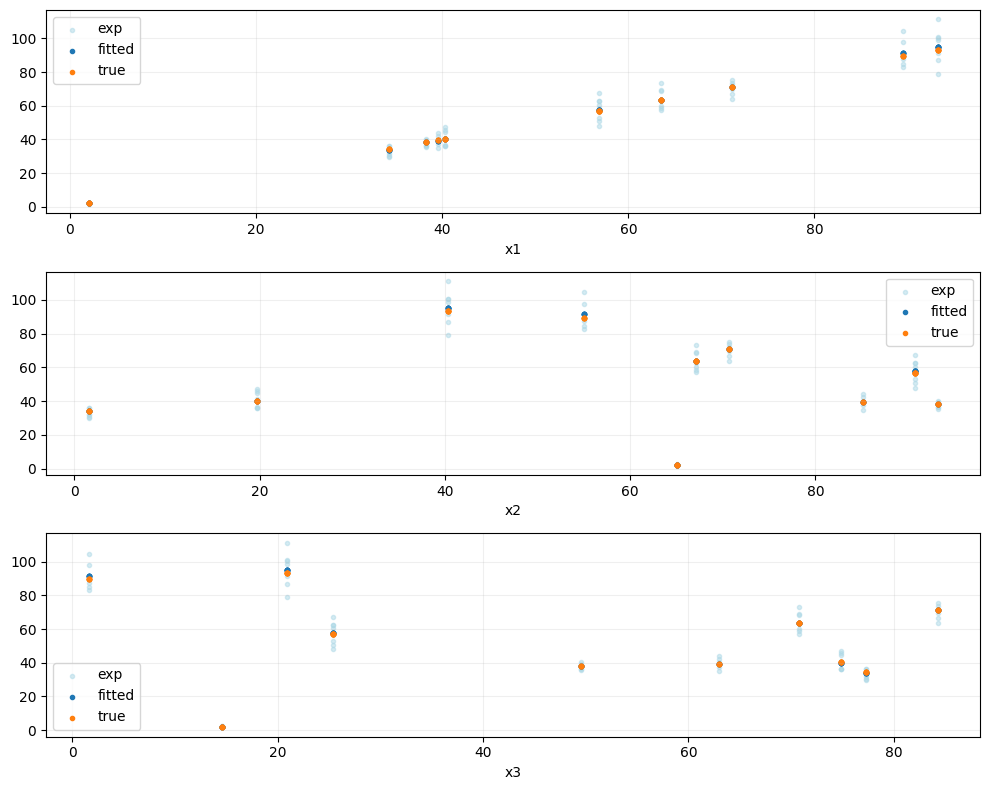

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(10,8))
for i in range(3):
    ax = fig.add_subplot(3, 1, i+1)
    ax.scatter(df[f'x{i+1}'], df['y'], marker='.', alpha=0.5, label='exp', c='lightblue')
    ax.scatter(df[f'x{i+1}'], results_ols.fittedvalues, marker='.', label='fitted', c='C0')
    ax.scatter(df[f'x{i+1}'], df['y_true'], marker='.', label='true', c='C1')
    ax.set_xlabel(f'x{i+1}')
    ax.grid(alpha=0.2)
    ax.legend()
plt.tight_layout()

# 凡例は以下の通りです。
# exp：測定値(上記で作成したデータ)
# fitted：OLSのフィッティング結果
# true：誤差項がない場合の値


$x1$の増加に従って線形に増加していることが確認できました。また同じグラフから、データのばらつきが $x1$ に対して均一になっていないことが懸念されます。

# 回帰診断
OLSの結果との残差プロットおよびQ-Qプロットを確認します。$x1$ の増加に従って残差が増加していることから、不均一分散の傾向が確認されます(左図)。一方でQ-Qプロットはおおよそ直線の傾向が確認されることから、誤差項は正規分布に従うものと考えられます(右図)。以上よりモデルとしては線形回帰モデルで十分ではありますが、通常のOLSに加えて、不均一分散に対応可能な重み付き最小二乗法(WLS)も検討する必要があります。

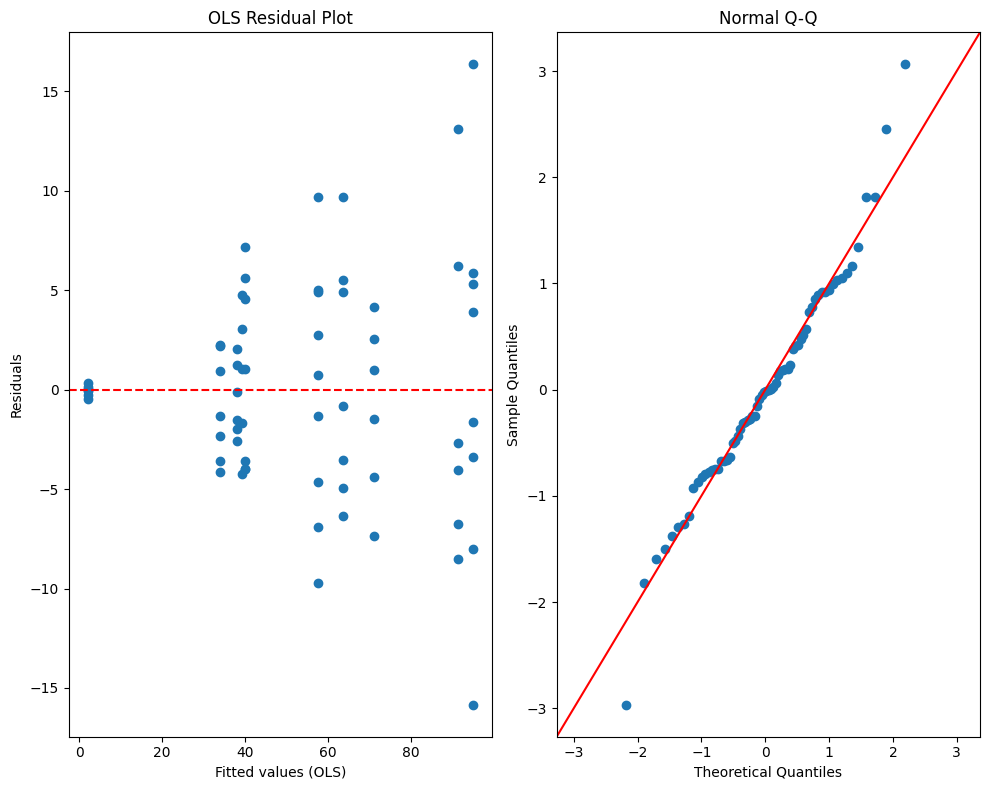

In [5]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# 残差プロット
ax1.plot()
ax1.scatter(results_ols.fittedvalues, results_ols.resid)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Fitted values (OLS)')
ax1.set_ylabel('Residuals')
ax1.set_title('OLS Residual Plot')

# QQプロット
sm.qqplot((results_ols.resid-np.mean(results_ols.resid))/np.std(results_ols.resid), ax=ax2, line='45')
ax2.set_title('Normal Q-Q')
plt.tight_layout()

# グループ付き交差検証によるモデルの評価
データセットは同様の説明変数列に対して複数の観測点を含んでいます。学習モデルの過学習を防ぐため、ここではscikit-learnのGroupKFoldを使用し、同じ説明変数列をgroupラベルで分類して交差検証を行います。組み合わせの細かさとテストに用いる説明変数列の数のバランスを考慮し、分割数を5(テストデータは３つの説明変数列)で行います。モデルは前述の通りOLSとWLSの線形回帰モデルを検討します。WLSモデルの重みは $x1$ の逆数を用いることにします。

In [6]:
groups = df['group']
group_kfold = GroupKFold(n_splits=5)

# 説明変数のパターン
patterns = [['x1'], ['x1', 'x2'], ['x1', 'x3'], ['x1', 'x2', 'x3']]

# 結果を保存するための空のDataFrameを作成
results = pd.DataFrame(columns=['Pattern', 'MSE', 'R^2', 'AIC', 'BIC', 'Model'])

# 各パターンでモデルを訓練し、評価指標を計算
for pattern in patterns:
    pattern_str = ', '.join(pattern)  # パターンを文字列に変換
    for train_index, test_index in group_kfold.split(X, y, groups):
        # 訓練データとテストデータを取得
        X_train, X_test = X[pattern].iloc[train_index], X[pattern].iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 定数項を追加
        X_train = sm.add_constant(X_train, has_constant='add')
        X_test = sm.add_constant(X_test, has_constant='add')

        # OLS
        model_ols = sm.OLS(y_train, X_train).fit()

        # WLS (重みはOLSの残差を使用)
        weights = 1.0 / (X_train['x1'])
        model_wls = sm.WLS(y_train, X_train, weights=weights).fit()

        # テストデータで予測
        y_pred_ols = model_ols.predict(X_test)
        y_pred_wls = model_wls.predict(X_test)

        # 結果を格納した行を作成
        new_row_ols = pd.DataFrame({
            'Pattern': [pattern_str],
            'MSE': [mean_squared_error(y_test, y_pred_ols)],
            'R^2': [r2_score(y_test, y_pred_ols)],
            'AIC': [model_ols.aic],
            'BIC': [model_ols.bic],
            'Model': ['OLS'],
        })

        new_row_wls = pd.DataFrame({
            'Pattern': [pattern_str],
            'MSE': [mean_squared_error(y_test, y_pred_wls)],
            'R^2': [r2_score(y_test, y_pred_wls)],
            'AIC': [model_wls.aic],
            'BIC': [model_wls.bic],
            'Model': ['WLS'],
        })

        # 結果を既存のDataFrameに結合
        results = pd.concat([results, new_row_ols, new_row_wls], ignore_index=True)

# 各評価指標の平均値を計算
results_grouped = results.groupby(['Pattern', 'Model']).mean().round(2)

# 結果を表示
display(results_grouped)


MSE   R^2     AIC     BIC
Pattern    Model                             
x1         OLS    28.89  0.86  340.49  344.48
           WLS    29.02  0.86  312.25  316.25
x1, x2     OLS    29.28  0.86  342.42  348.41
           WLS    29.50  0.86  314.00  319.99
x1, x2, x3 OLS    29.57  0.86  343.85  351.83
           WLS    29.42  0.86  315.25  323.23
x1, x3     OLS    28.89  0.86  341.93  347.91
           WLS    28.83  0.86  313.35  319.34

MSEやR2はどれも大差はありませんが、AICやBICは全体的にWLSの方が小さくなっています。また変数の組み合わせについても、$x1$ だけを用いた場合にAICやBICが小さくなっていることが確認できます。以上より、最有力なモデルは $x1$についてのWLSの単回帰モデルとなります。

# OLS vs WLS
以下では $x1$の単回帰モデルを作成します。WLSとOLSの違いも合わせて確認するため、以下ではこれら両方のモデルの予測範囲を確認することにします。グラフの薄い色の部分が予測される範囲になります。

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.796219,1.484945,-4.734878,3.142440,-15.776536,14.184098
1,0.236711,1.462452,-3.642289,4.115710,-14.728031,15.201453
2,1.269640,1.440048,-2.549933,5.089214,-13.679808,16.219089
3,2.302570,1.417736,-1.457824,6.062964,-12.631868,17.237008
4,3.335500,1.395521,-0.365971,7.036971,-11.584211,18.255210
...,...,...,...,...,...,...
95,97.332099,1.249825,94.017072,100.647127,82.503536,112.160662
96,98.365029,1.271255,94.993162,101.736896,83.523656,113.206402
97,99.397959,1.292819,95.968895,102.827022,84.543486,114.252431
98,100.430888,1.314511,96.944289,103.917488,85.563029,115.298748


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.060459,0.362196,-1.021146,0.900228,-2.072561,1.951643
1,0.958547,0.355518,0.015574,1.901520,-1.045158,2.962252
2,1.977554,0.349204,1.051327,2.903780,-0.018325,3.973432
3,2.996560,0.343275,2.086059,3.907061,1.007931,4.985190
4,4.015567,0.337751,3.119718,4.911415,2.033603,5.997530
...,...,...,...,...,...,...
95,96.745152,1.100275,93.826790,99.663514,93.333045,100.157259
96,97.764158,1.112864,94.812405,100.715912,94.323449,101.204868
97,98.783165,1.125465,95.797989,101.768341,95.313740,102.252590
98,99.802171,1.138077,96.783542,102.820801,96.303921,103.300422


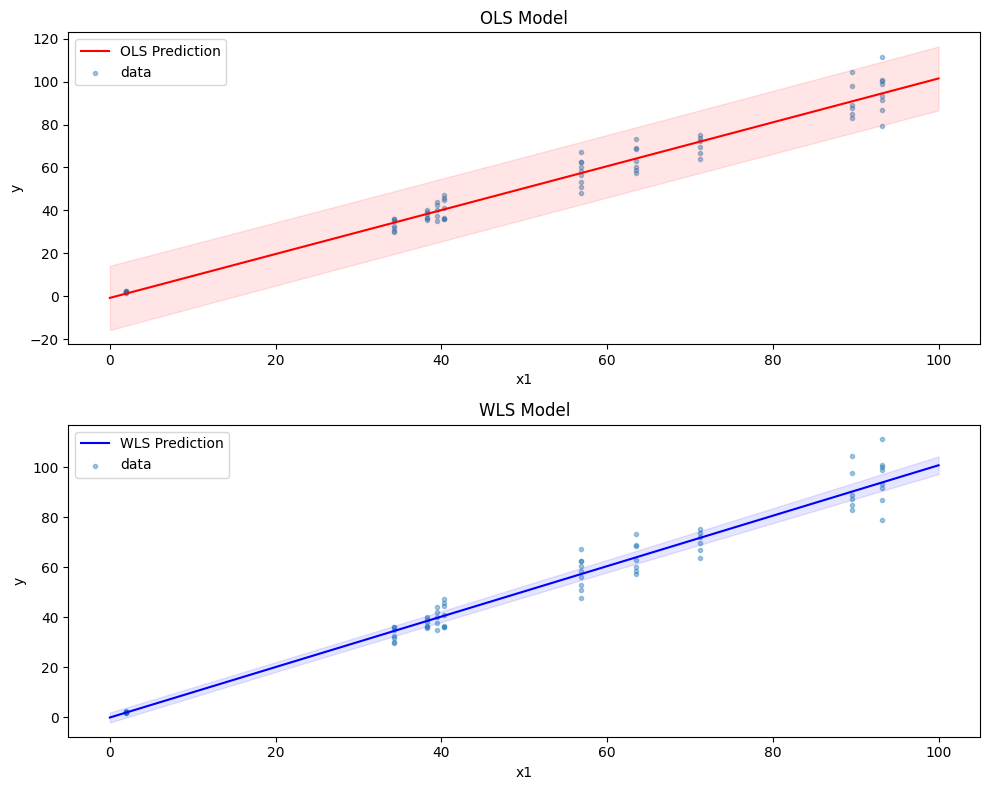

In [7]:
# 改めてモデルを作成
X1 = df[['x1']]
X1 = sm.add_constant(X1)

# OLS
model_ols = sm.OLS(y, X1)
results_ols = model_ols.fit()

# WLS
weights = 1.0 / (X1['x1'])
model_wls = sm.WLS(y, X1, weights=weights)
results_wls = model_wls.fit()

# 予測値と信頼区間
x = np.linspace(0, 100, 100)
x = sm.add_constant(x)
predictions_ols = results_ols.get_prediction(x)
predictions_wls = results_wls.get_prediction(x)

# 予測値と信頼区間
predictions_ols_summary_frame = predictions_ols.summary_frame(alpha=0.01)
predictions_wls_summary_frame = predictions_wls.summary_frame(alpha=0.01)

display(predictions_ols_summary_frame)
display(predictions_wls_summary_frame)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(x[:, 1], predictions_ols_summary_frame['mean'], 'r', label='OLS Prediction')
plt.scatter(df['x1'], df['y'], label='data', alpha=0.4, marker='.')
plt.fill_between(x[:, 1], predictions_ols_summary_frame['obs_ci_lower'], predictions_ols_summary_frame['obs_ci_upper'], color='r', alpha=0.1)
plt.title('OLS Model')
plt.xlabel('x1')
plt.ylabel('y')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x[:, 1], predictions_wls_summary_frame['mean'], 'b', label='WLS Prediction')
plt.scatter(df['x1'], df['y'], label='data', alpha=0.4, marker='.')
plt.fill_between(x[:, 1], predictions_wls_summary_frame['obs_ci_lower'], predictions_wls_summary_frame['obs_ci_upper'], color='b', alpha=0.1)
plt.title('WLS Model')
plt.xlabel('x1')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

上記のグラフから、OLSはデータに対して均一な幅の予測区間を設けていることが分かります。一方でWLSでは(若干ですが) $x1$の増加に従って予測区間が広がっており、データの特徴を捉えていることが分かります。ただし予測区間が狭く実用には耐えられません。そこで以下ではWLSの重みを調整して、予測区間の改善を図ります。

# WLSの重みの設定
この章では、WLSの重みをクロスバリデーションによって最適化します。重みのパラメータは $ 1/{(x1)^p}$ の $p$であり、これを1~10の範囲で0.1刻みで評価します。評価指標には予測区間に関連する指標である以下のものも加えることにします。
- PICP ：予測区間にデータが収まる割合
- MPIW：予測区間の幅(予測区間の上限-予測区間の下限)

In [8]:
# 結果を保存するための空のDataFrameを作成
results_wls = pd.DataFrame(columns=['POW', 'MSE', 'R^2', 'AIC', 'BIC','PICP', 'MPIW'])

# 重みは1~10までの0.1刻みとする
pow_weights = np.arange(1, 10, 0.1)

# 各パターンでモデルを訓練し、評価指標を計算
for train_index, test_index in group_kfold.split(X1, y, groups):

    # 訓練データとテストデータを取得
    X_train, X_test = X1['x1'].iloc[train_index], X1['x1'].iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 定数項を追加
    X_train = sm.add_constant(X_train, has_constant='add')
    X_test = sm.add_constant(X_test, has_constant='add')

    for p in pow_weights:
        weights = 1.0 / (np.power(X_train['x1'], p))
        model = sm.WLS(y_train, X_train, weights=weights).fit()

        # テストデータで予測
        y_pred = model.get_prediction(X_test)
        pred_summary = y_pred.summary_frame(alpha=0.05)  # 95%予測区間

        # 予測区間の平均と下限・上限を取得
        y_mean = pred_summary['mean']
        obs_ci_lower = pred_summary['obs_ci_lower']
        obs_ci_upper = pred_summary['obs_ci_upper']

        # 結果を格納した行を作成
        new_row = pd.DataFrame({
            'POW': [str(np.round(p,1))],
            'MSE': [mean_squared_error(y_test, y_mean)],
            'R^2': [r2_score(y_test, y_mean)],
            'AIC': [model.aic],
            'BIC': [model.bic],
            'PICP': [np.mean((y_test >= obs_ci_lower) & (y_test <= obs_ci_upper))],
            'MPIW': [np.mean(obs_ci_upper - obs_ci_lower)]
        })

        # 結果を既存のDataFrameに結合
        results_wls= pd.concat([results_wls, new_row], ignore_index=True)

# 各評価指標の平均値を計算
results_grouped_wls = results_wls.groupby(['POW']).mean().round(4).reset_index()

# 結果を表示
display(results_grouped_wls)


,POW,MSE,R^2,AIC,BIC,PICP,MPIW
0,1.0,29.0219,0.8578,312.2534,316.2460,0.3934,4.8230
1,1.1,29.0403,0.8577,309.8530,313.8456,0.3637,4.5144
2,1.2,29.0595,0.8576,307.5756,311.5683,0.3341,4.2920
3,1.3,29.0794,0.8576,305.4467,309.4394,0.3341,4.1349
4,1.4,29.1004,0.8575,303.5001,307.4928,0.3341,4.0272
...,...,...,...,...,...,...,...
85,9.5,33.1234,0.8400,1193.5507,1197.5434,0.9286,107438.3413
86,9.6,33.2072,0.8396,1206.5138,1210.5065,0.9286,124236.0320
87,9.7,33.2939,0.8392,1219.4780,1223.4706,0.9286,143653.2332
88,9.8,33.3838,0.8388,1232.4430,1236.4357,0.9286,166097.5954


各重みごとに計算ができたのでグラフに描画します。採用する重みは以下の指標で決めることにします：
$$ score = -MSE + R^2 - AIC - BIC + PICP - MPIW $$
この $score$ は各指標が優れた値をもつほど大きくなります。このデータセットでは $p=3.7$ が最適な重みとなりました。  

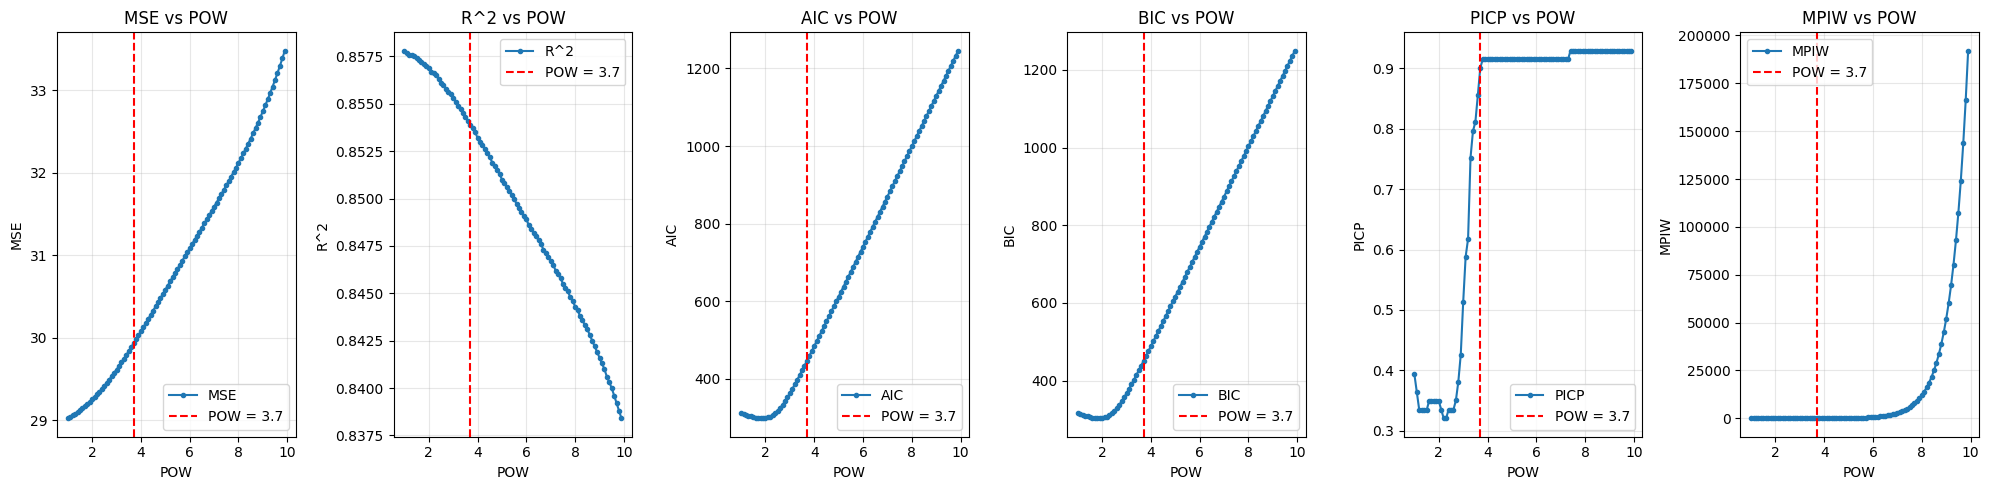

In [9]:
# POWを数値に変換
results_grouped_wls['POW'] = results_grouped_wls['POW'].astype(float)

# POWの小さい順にソート
results_wls = results_grouped_wls.sort_index()

# 指標のリスト
metrics = ['MSE', 'R^2', 'AIC', 'BIC', 'PICP', 'MPIW']

# MinMaxScalerを使用して正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_norm = results_wls.copy()
df_norm[metrics] = scaler.fit_transform(results_wls[metrics])

# スコアを計算
df_norm['score'] = - df_norm['MSE'] + df_norm['R^2'] - df_norm['AIC'] - df_norm['BIC'] + df_norm['PICP'] - df_norm['MPIW']
best_pow = df_norm['POW'].iloc[df_norm['score'].idxmax()]

# 各指標の折れ線グラフを作成
fig = plt.figure(figsize=(20,5))
for i, metric in enumerate(metrics):
    ax = fig.add_subplot(1, len(metrics),i+1)
    ax.plot(results_wls['POW'], results_wls[metric], marker='.', linestyle='-', label=metric)
    ax.axvline(x=best_pow, color='r', linestyle='--', label=f'POW = {best_pow:.1f}')
    ax.set_xlabel('POW')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs POW')
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

最後に決定した重みで予測区間を再計算します。データの特徴を上手く捉えており、 $x1$ が小さいところでは予測区間が狭く、 $x1$ が大きくなるにつれて予測区間が広がっていることが確認できます。

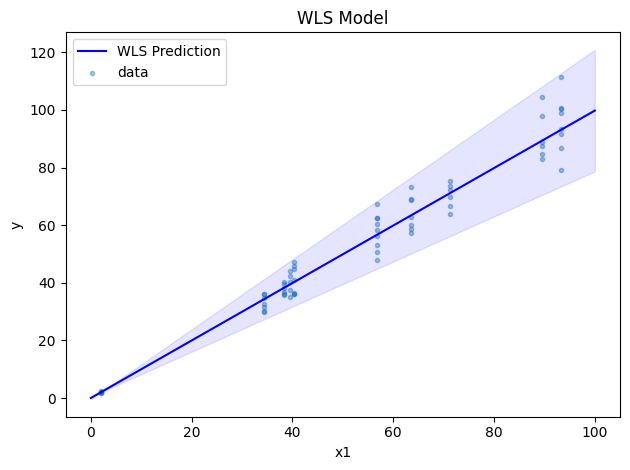

In [10]:
weights = 1.0 / np.power((X1['x1']), best_pow)
model_wls = sm.WLS(y, X1, weights=weights)
results_wls = model_wls.fit()
predictions_wls = results_wls.get_prediction(x)
predictions_wls_summary_frame = predictions_wls.summary_frame(alpha=0.01)

plt.plot(x[:, 1], predictions_wls_summary_frame['mean'], 'b', label='WLS Prediction')
plt.scatter(df['x1'], df['y'], label='data', alpha=0.4, marker='.')
plt.fill_between(x[:, 1], predictions_wls_summary_frame['obs_ci_lower'], predictions_wls_summary_frame['obs_ci_upper'], color='b', alpha=0.1)
plt.title('WLS Model')
plt.xlabel('x1')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()